# CheckList perturbations

In [1]:
!pip install pandas==1.2.3
!pip install numpy==1.20.2
!pip install jupyterlab==3.0.12
!pip install matplotlib==3.4.1
!pip install seaborn==0.11.1
!pip install shap==0.39.0
!pip install torch==1.7.1
!pip install pytreebank==0.2.7
!pip install transformers==4.3.3
!pip install ipywidgets==7.6.3
!pip install tqdm==4.59.0
!pip install checklist==0.0.10
!pip install allennlp==2.1.0

     |████████████████████████████████| 9.9MB 5.9MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


     |████████████████████████████████| 15.3MB 378kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


     |████████████████████████████████| 8.3MB 3.8MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 430kB 26.1MB/s 
     |████████████████████████████████| 378kB 54.0MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
     |████████████████████████████████| 122kB 52.0MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
 

     |████████████████████████████████| 10.3MB 5.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 358kB 4.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491648 sha256=f6b685c2bf578251f25c613fce736cc0142d1a0b64c2208d5370b376d271fe3f
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Created wheel for pytreebank: filename=pytreebank-0.2.7-cp37-none-any.whl size=37070 sha256=a0b67d7f71ddf71abcd83012db4e7e3d23e27ca0a8aecc9808ee09c10c45f174
  Stored in directory: /root/.cache/pip/wheels/e0/b6/91/e9edcdbf464f623628d5c3aa9de28888c7

In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import torch
import spacy
from torch.utils.data import \
    TensorDataset, \
    DataLoader
from transformers import \
    BertTokenizer, \
    BertForSequenceClassification, \
    AdamW, \
    BertConfig, \
    get_linear_schedule_with_warmup
import pytreebank
from tqdm import tqdm
import shap
from checklist.perturb import Perturb

In [ ]:
# os.chdir('../..')

## Load data

In [2]:
dataset = pytreebank.load_sst("data/raw/stanford_sentiment_treebank/")

In [3]:
train = dataset['train']
dev = dataset['dev']
# test = dataset['test']

In [4]:
def stanford_raw_to_df(pytree_dataset):
    """
    Convert list of pytreebank LabeledTree objects to DataFrame of full-sentence examples with labels
    """
    labels = []
    sentences = []
    
    for labeled_tree_obj in pytree_dataset:
        lab, sent = labeled_tree_obj.to_labeled_lines()[0]  # First index contains full sentence
        labels.append(lab)
        sentences.append(sent)
        
    output_df = pd.DataFrame(
        {
            'sentence': sentences,
            'label': labels
        }
    )
    
    return output_df

In [5]:
train_df = stanford_raw_to_df(train)
print(train_df.shape)
train_df.head()

(8544, 2)


,sentence,label
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8544 entries, 0 to 8543
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  8544 non-null   object
 1   label     8544 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.6+ KB


In [7]:
dev_df = stanford_raw_to_df(dev)
print(dev_df.shape)
dev_df.head()

(1101, 2)


,sentence,label
0,It 's a lovely film with lovely performances b...,3
1,"No one goes unindicted here , which is probabl...",2
2,And if you 're not nearly moved to tears by a ...,3
3,"A warm , funny , engaging film .",4
4,Uses sharp humor and insight into human nature...,4


## Load fine-tuned BERT

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
os.listdir()

['.config', 'drive', 'data', 'sample_data']

In [11]:
bert_model = BertForSequenceClassification.from_pretrained("drive/My Drive/Colab Notebooks/fine-tuned-bert-base-sst")

In [12]:
%%capture
bert_model.to(device)

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [14]:
MAX_LENGTH = 70  # Max length of input sequence

In [15]:
def pad_sentence_at_end(sentence, max_length):
    """
    Pad tokenised sentence with zeros at end
    
    :param: sentence: list of encodings for a sentence
    :param: max_length: max length to pad up to
    """
    num_zeros_to_add = max_length - len(sentence)
    zero_list = list(
        np.zeros(num_zeros_to_add).astype(int)
    )
    padded_sentence = sentence + zero_list
    return np.array(padded_sentence)


def create_sentence_input_arrays(list_encoded_sentences, max_length):
    """
    Create input arrays for BERT
    
    :param: list_encoded_sentences: List of sentence encoding lists
    :param: max_length: max length to pad up to
    """
    encoded_sentences = [pad_sentence_at_end(sent, max_length) for sent in list_encoded_sentences]
    
    train_array = np.vstack(encoded_sentences)
    
    train_attention_mask_array = (train_array != 0).astype(int)
    
    return train_array, train_attention_mask_array

In [16]:
def make_predictions(df, model, tokenizer, sentence_col_name):

    #==========================================#
    # PREPARE DATA                             #
    #==========================================#

    df = df.copy()

    encoded_sentences = []

    for sentence in df['sentence'].values:
        enc_sent_as_list = tokenizer.encode(sentence, add_special_tokens=True)
        encoded_sentences.append(enc_sent_as_list)

    input_array, input_attention_mask_array = create_sentence_input_arrays(
        encoded_sentences, 
        MAX_LENGTH
    )

    input_tensor = torch.tensor(input_array)
    input_attention_mask_tensor = torch.tensor(input_attention_mask_array)
    input_labels_tensor = torch.tensor(df['label'].values)

    input_dataset = TensorDataset(input_tensor, input_attention_mask_tensor, input_labels_tensor)

    input_data_loader = DataLoader(input_dataset, batch_size=32)

    #==========================================#
    # RUN MODEL                                #
    #==========================================#

    model.eval()

    predicted_labels = []

    for batch in tqdm(input_data_loader):

        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=batch_input_ids,
                token_type_ids=None,
                attention_mask=batch_attention_mask
            )

        logits = outputs[0]

        batch_pred_labels = list(
            torch.argmax(logits, dim=1).cpu().numpy()
        )
        predicted_labels = predicted_labels + batch_pred_labels

    return np.array(predicted_labels)

In [17]:
# train_predictions = make_predictions(train_df, bert_model, tokenizer, 'sentence')

## Checklist utilities

In [18]:
%%capture
!python -m spacy download en_core_web_sm

In [19]:
nlp = spacy.load('en_core_web_sm')

In [20]:
def add_checklist_perturbations(
    df, sentence_col_name, strip_punct=True, add_typos=True, contract_sent=True, change_names=True, seed=3
):
    df = df.copy()
    
    np.random.seed(seed)  # Set seed as some perturbations are stochastic
    
    if strip_punct or change_names:
        # Checklist requires pre-processing with Spacy for these perturbations
        pdata = list(nlp.pipe(df[sentence_col_name]))
    
    # Strip trailing punctuation
    
    if strip_punct:
        
        stripped_sentences = [Perturb.strip_punctuation(pdata[i]) for i in range(len(pdata))]
        
        df[sentence_col_name + '_strip_punct'] = stripped_sentences
        
        # Create success flag as not all sentences will contain punctuation:
        df['success_strip_punct'] = np.where(
            df[sentence_col_name + '_strip_punct'] != df[sentence_col_name],
            1,
            0
        )
    
    # Add typos
    
    if add_typos:
        sentences_w_typos = [Perturb.add_typos(df[sentence_col_name][i]) for i in range(len(df))]
        
        df[sentence_col_name + '_add_typos'] = sentences_w_typos
        
        # Create success flag
        df['success_add_typos'] = np.where(
            df[sentence_col_name + '_add_typos'] != df[sentence_col_name],
            1,
            0
        )
    
    # Contract sentence length by using abbreviations
    
    if contract_sent:
        sentences_contracted = [Perturb.contract(df[sentence_col_name][i]) for i in range(len(df))]
        
        df[sentence_col_name + '_contract_sent'] = sentences_contracted
        
        # Create success flag
        df['success_contract_sent'] = np.where(
            df[sentence_col_name + '_contract_sent'] != df[sentence_col_name],
            1,
            0
        )
        
    if change_names:
        # Only returns sentences with successful perturbations else drops
        change_name_raw_output = Perturb.perturb(
            pdata, 
            Perturb.change_names, 
            keep_original=True,  # Keeps original sentence
            n=1  # Number of replacements to generate
        )['data']
        
        # key=original, value=perturbed
        original_to_pert = dict(
            zip(
                [sent_pair[0] for sent_pair in change_name_raw_output],
                [sent_pair[1] for sent_pair in change_name_raw_output]
            )
        )
        
        # Un-perturbed sentences will be null
        df[sentence_col_name + '_change_names'] = df[sentence_col_name].map(original_to_pert)
        
        # Success flag
        df['success_change_names'] = np.where(
            ~df[sentence_col_name + '_change_names'].isnull(),
            1,
            0
        )
        
        # Fill nulls with original
        df[sentence_col_name + '_change_names'] = np.where(
            df[sentence_col_name + '_change_names'].isnull(),
            df[sentence_col_name],
            df[sentence_col_name + '_change_names']
        )
        
    return df

Aside: How do name changes work?

In [21]:
name_check_df = pd.DataFrame({'sentence': ['Saka finished the cross from Tierney', 'Bukayo Saka finished the cross from Kieran Tierney', "John Smith headed the ball in from an Ian Smith corner"]})
name_check_df

,sentence
0,Saka finished the cross from Tierney
1,Bukayo Saka finished the cross from Kieran Tie...
2,John Smith headed the ball in from an Ian Smit...


In [22]:
add_checklist_perturbations(name_check_df, 'sentence')[['sentence', 'sentence_change_names']]

,sentence,sentence_change_names
0,Saka finished the cross from Tierney,Saka finished the cross from Tierney
1,Bukayo Saka finished the cross from Kieran Tie...,Bukayo Saka finished the cross from Michael Lee
2,John Smith headed the ball in from an Ian Smit...,Michael Wood headed the ball in from an Ian Sm...


https://github.com/marcotcr/checklist/blob/master/checklist/perturb.py#L440

Uses pre-defined list of names: https://github.com/marcotcr/checklist/blob/master/checklist/data/names.json

## SHAP utilities

In [23]:
# set mapping between label and id
id2label = bert_model.config.id2label
label2id = bert_model.config.label2id
labels = sorted(label2id, key=label2id.get)

In [24]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128,truncation=True) for v in x]).cuda()
    attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = bert_model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [25]:
explainer = shap.Explainer(f,tokenizer,output_names=labels)

## Top-K intersections

Method:
1. Make predictions on development set
1. Apply CheckList perturbations to input sentences in development set
1. Make predictions on perturbed sentences
1. Keep examples for which:
  1. Perturbation is successful
  1. Prediction is correct
  1. Prediction of original sentence and perturbed sentence are the same
1. Compute SHAP values for original and perturbed sentences
1. Rank sentence tokens by SHAP value for original and perturbed sentences
1. Compute top-K intersection

In [26]:
print(dev_df.shape)
dev_df.head()

(1101, 2)


,sentence,label
0,It 's a lovely film with lovely performances b...,3
1,"No one goes unindicted here , which is probabl...",2
2,And if you 're not nearly moved to tears by a ...,3
3,"A warm , funny , engaging film .",4
4,Uses sharp humor and insight into human nature...,4


In [27]:
dev_predictions = make_predictions(dev_df, bert_model, tokenizer, 'sentence')
dev_df['predictions'] = dev_predictions
(dev_df['predictions'] == dev_df['label']).mean()

100%|██████████| 35/35 [00:01<00:00, 25.27it/s]


0.5213442325158947

In [28]:
# Make Checklist perturbations
dev_df_checklisted = add_checklist_perturbations(dev_df, 'sentence')

In [29]:
dev_df_checklisted.head()

,sentence,label,predictions,sentence_strip_punct,success_strip_punct,sentence_add_typos,success_add_typos,sentence_contract_sent,success_contract_sent,sentence_change_names,success_change_names
0,It 's a lovely film with lovely performances b...,3,4,It 's a lovely film with lovely performances b...,1,It 's a lovely film with lovely performancse b...,1,It 's a lovely film with lovely performances b...,0,It 's a lovely film with lovely performances b...,0
1,"No one goes unindicted here , which is probabl...",2,2,"No one goes unindicted here , which is probabl...",1,"No one goes unindicted hree , which is probabl...",1,"No one goes unindicted here , which is probabl...",0,"No one goes unindicted here , which is probabl...",0
2,And if you 're not nearly moved to tears by a ...,3,4,And if you 're not nearly moved to tears by a ...,1,Andi f you 're not nearly moved to tears by a ...,1,And if you 're not nearly moved to tears by a ...,0,And if you 're not nearly moved to tears by a ...,0
3,"A warm , funny , engaging film .",4,4,"A warm , funny , engaging film",1,"A warm , funny , engagin gfilm .",1,"A warm , funny , engaging film .",0,"A warm , funny , engaging film .",0
4,Uses sharp humor and insight into human nature...,4,3,Uses sharp humor and insight into human nature...,1,sUes sharp humor and insight into human nature...,1,Uses sharp humor and insight into human nature...,0,Uses sharp humor and insight into human nature...,0


In [30]:
# Make predictions on perturbed sentences
for perturb in ['_strip_punct', '_add_typos', '_contract_sent', '_change_names']:
    dev_predictions = make_predictions(dev_df_checklisted, bert_model, tokenizer, 'sentence'+perturb)
    dev_df_checklisted['predictions'+perturb] = dev_predictions

100%|██████████| 35/35 [00:01<00:00, 26.24it/s]


### Name change perturbation

In [31]:
change_names_dev_df = dev_df_checklisted.copy()[
  (dev_df_checklisted['success_change_names'] == 1) &  # Successfully perturbed
  (dev_df_checklisted['predictions_change_names'] == dev_df_checklisted['predictions']) &  # Prediction unchanged
  (dev_df_checklisted['label'] == dev_df_checklisted['predictions'])  # Correct prediction
].reset_index(drop=True)

change_names_dev_df.shape

(58, 15)

In [32]:
# Compute SHAP values before and after:
shap_values_before = explainer(change_names_dev_df['sentence'])

Partition explainer: 59it [00:14,  1.32it/s]


In [33]:
shap_values_after = explainer(change_names_dev_df['sentence_change_names'])

Partition explainer: 59it [00:13,  1.13it/s]


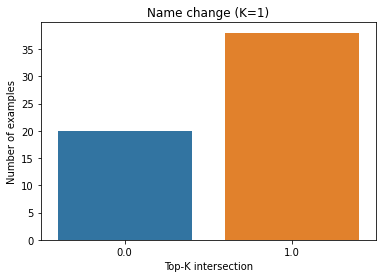

Mean top-K intersection: 0.6551724137931034


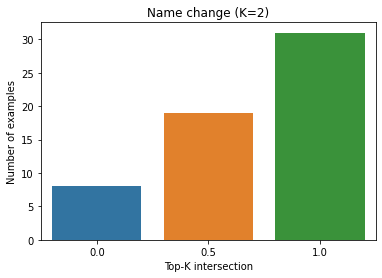

Mean top-K intersection: 0.6982758620689655


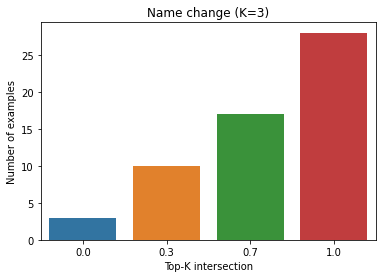

Mean top-K intersection: 0.7396551724137932


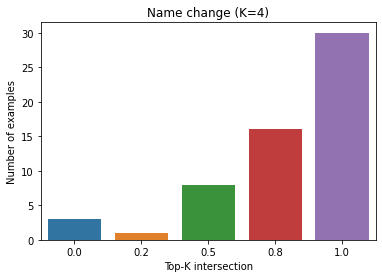

Mean top-K intersection: 0.8103448275862067


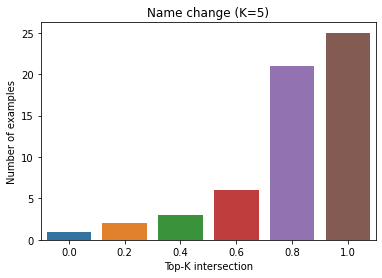

Mean top-K intersection: 0.8103448275862069


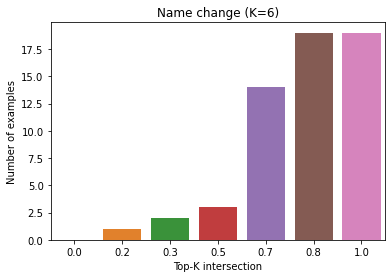

Mean top-K intersection: 0.7982758620689656


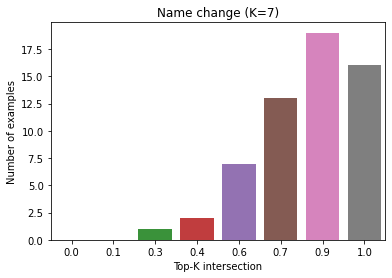

Mean top-K intersection: 0.8189655172413793


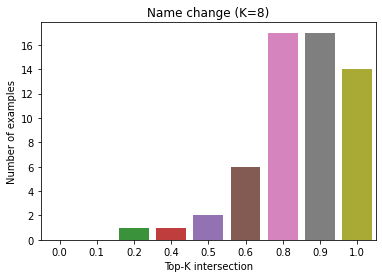

Mean top-K intersection: 0.8293103448275863


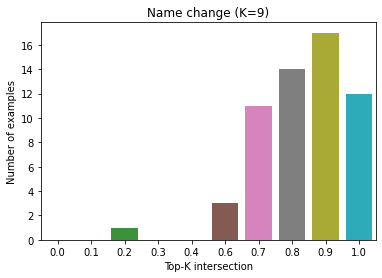

Mean top-K intersection: 0.8310344827586207


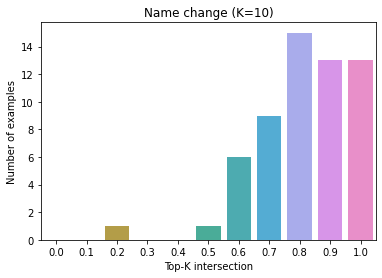

Mean top-K intersection: 0.8155172413793104


In [ ]:
for K in range(1, 11):

  top_k_intersection_list = []

  for example in range(len(change_names_dev_df)):
    label = change_names_dev_df.loc[example]['label']

    # Create DataFrame of sorted SHAP values _before_ perturbation
    original_shap_ranked_example = pd.DataFrame(
      {
          'shap_values': shap_values_before[example, :, f"LABEL_{label}"].values,
          'token': shap_values_before[example, :, f"LABEL_{label}"].data
      }
    ).sort_values('shap_values', ascending=False)

    # Create DataFrame of sorted SHAP values _after_ perturbation
    perturbed_shap_ranked_example = pd.DataFrame(
      {
          'shap_values': shap_values_after[example, :, f"LABEL_{label}"].values,
          'token': shap_values_after[example, :, f"LABEL_{label}"].data
      }
    ).sort_values('shap_values', ascending=False)

    # Find intersection between top-K tokens
    top_k_tokens_original = set(original_shap_ranked_example.head(K)['token'].values)
    top_k_tokens_perturbed = set(perturbed_shap_ranked_example.head(K)['token'].values)

    num_common_top_k_tokens = len(
      top_k_tokens_original.intersection(top_k_tokens_perturbed)
    )

    top_k_intersection = num_common_top_k_tokens / K
    top_k_intersection_list.append(top_k_intersection)

  # Plot
  top_k_intersection_arr = np.round(
      np.array(top_k_intersection_list), 1
  )
  mean_top_k = np.mean(top_k_intersection_arr)

  # Find any missing proportions to allow full plot on x-axis
  missing_labels = list(
      set(np.round(np.arange(0, 1.1, 1/K), 1)) - set(top_k_intersection_arr)
  )

  labels, counts = np.unique(top_k_intersection_arr, return_counts=True)
  labels = np.concatenate((labels, np.array(missing_labels)))
  counts = np.concatenate(
      (counts, np.zeros(len(missing_labels)))
  )
  plt.xlabel(f'Top-K intersection')
  plt.ylabel(f'Number of examples')
  plt.title(f'Name change (K={K})')
  sns.barplot(x=labels, y=counts)
  plt.show()
  print(f'Mean top-K intersection: {mean_top_k}')

## Wrap steps into function and repeat for all pertubation types

In [ ]:
def compute_before_after_shap_values(df, orig_sent_col_name, perturbation_name):
  shap_values_before = explainer(df[orig_sent_col_name])
  shap_values_after = explainer(df['sentence_' + perturbation_name])

  return shap_values_before, shap_values_after


def plot_perturbations(df, perturbation_name, k_values=range(1, 11)):

  df = df.copy()
  
  shap_values_before, shap_values_after = compute_before_after_shap_values(df, orig_sent_col_name='sentence', perturbation_name=perturbation_name)

  for K in k_values:

    top_k_intersection_list = []

    for example in tqdm(range(len(df))):
      label = df.loc[example]['label']

      # Create DataFrame of sorted SHAP values _before_ perturbation
      shap_for_example_before = shap_values_before[example, :, f"LABEL_{label}"]
      original_shap_ranked_example = pd.DataFrame(
        {
            'shap_values': shap_for_example_before.values,
            'token': shap_for_example_before.data
        }
      ).sort_values('shap_values', ascending=False)

      # Create DataFrame of sorted SHAP values _after_ perturbation
      shap_for_example_after = shap_values_after[example, :, f"LABEL_{label}"]
      perturbed_shap_ranked_example = pd.DataFrame(
        {
            'shap_values': shap_for_example_after.values,
            'token': shap_for_example_after.data
        }
      ).sort_values('shap_values', ascending=False)

      # Find intersection between top-K tokens
      top_k_tokens_original = set(original_shap_ranked_example.head(K)['token'].values)
      top_k_tokens_perturbed = set(perturbed_shap_ranked_example.head(K)['token'].values)

      num_common_top_k_tokens = len(
        top_k_tokens_original.intersection(top_k_tokens_perturbed)
      )

      top_k_intersection = num_common_top_k_tokens / K
      top_k_intersection_list.append(top_k_intersection)

    # Plot
    top_k_intersection_arr = np.round(
        np.array(top_k_intersection_list), 1
    )
    mean_top_k = np.mean(top_k_intersection_arr)

    # Find any missing proportions to allow full plot on x-axis
    missing_labels = list(
        set(np.round(np.arange(0, 1.1, 1/K), 1)) - set(top_k_intersection_arr)
    )

    labels, counts = np.unique(top_k_intersection_arr, return_counts=True)
    labels = np.concatenate((labels, np.array(missing_labels)))
    counts = np.concatenate(
        (counts, np.zeros(len(missing_labels)))
    )
    plt.xlabel(f'Top-K intersection')
    plt.ylabel(f'Number of examples')
    plt.title(f'{perturbation_name} (K={K})')
    sns.barplot(x=labels, y=counts)
    plt.show()
    print(f'Mean top-K intersection: {mean_top_k}')

### Name change perturbation

Partition explainer: 59it [00:17,  1.44it/s]
Partition explainer: 59it [00:17,  1.44it/s]
100%|██████████| 58/58 [00:00<00:00, 83.98it/s]


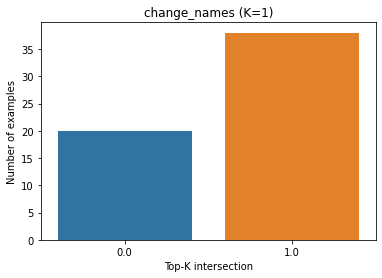

 16%|█▌        | 9/58 [00:00<00:00, 84.06it/s]

Mean top-K intersection: 0.6551724137931034


100%|██████████| 58/58 [00:00<00:00, 82.71it/s]


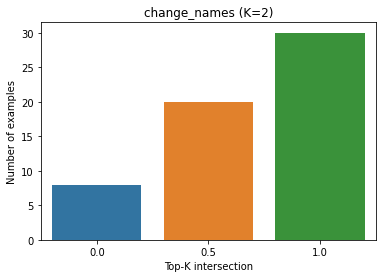

 16%|█▌        | 9/58 [00:00<00:00, 89.91it/s]

Mean top-K intersection: 0.6896551724137931


100%|██████████| 58/58 [00:00<00:00, 84.88it/s]


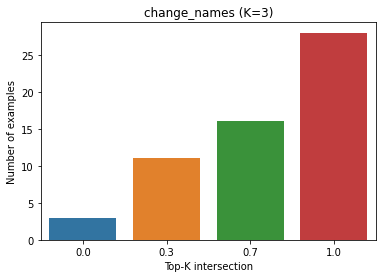

 16%|█▌        | 9/58 [00:00<00:00, 83.85it/s]

Mean top-K intersection: 0.7327586206896551


100%|██████████| 58/58 [00:00<00:00, 83.84it/s]


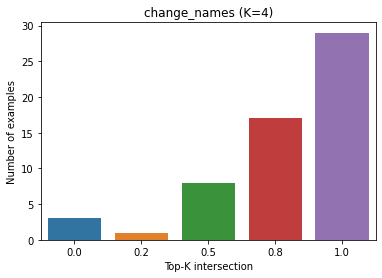

 16%|█▌        | 9/58 [00:00<00:00, 89.77it/s]

Mean top-K intersection: 0.8068965517241379


100%|██████████| 58/58 [00:00<00:00, 85.17it/s]


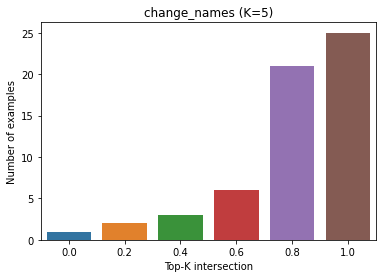

 16%|█▌        | 9/58 [00:00<00:00, 84.83it/s]

Mean top-K intersection: 0.8103448275862069


100%|██████████| 58/58 [00:00<00:00, 85.30it/s]


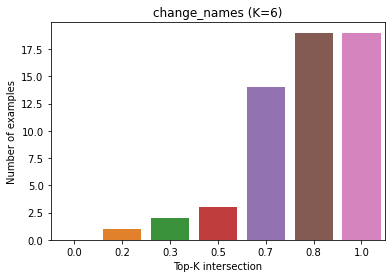

 16%|█▌        | 9/58 [00:00<00:00, 82.44it/s]

Mean top-K intersection: 0.7982758620689656


100%|██████████| 58/58 [00:00<00:00, 83.18it/s]


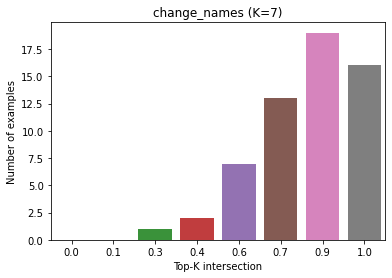

 16%|█▌        | 9/58 [00:00<00:00, 85.11it/s]

Mean top-K intersection: 0.8189655172413793


100%|██████████| 58/58 [00:00<00:00, 82.36it/s]


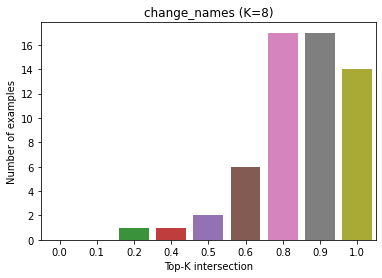

 28%|██▊       | 16/58 [00:00<00:00, 77.87it/s]

Mean top-K intersection: 0.8293103448275863


100%|██████████| 58/58 [00:00<00:00, 80.14it/s]


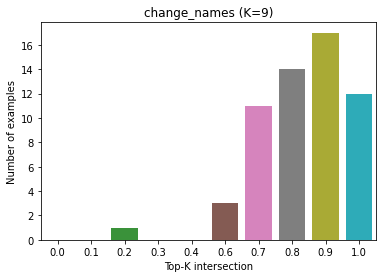

 16%|█▌        | 9/58 [00:00<00:00, 81.60it/s]

Mean top-K intersection: 0.8310344827586207


100%|██████████| 58/58 [00:00<00:00, 82.37it/s]


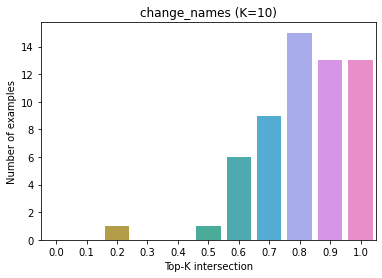

Mean top-K intersection: 0.8155172413793104


In [ ]:
plot_perturbations(df=change_names_dev_df, perturbation_name='change_names')

### Strip punctuation perturbation

In [ ]:
perturb_dev_df = dev_df_checklisted.copy()[
  (dev_df_checklisted['success_strip_punct'] == 1) &  # Successfully perturbed
  (dev_df_checklisted['predictions_strip_punct'] == dev_df_checklisted['predictions']) &  # Prediction unchanged
  (dev_df_checklisted['label'] == dev_df_checklisted['predictions'])  # Correct prediction
].reset_index(drop=True)

perturb_dev_df.shape

(566, 15)

Partition explainer: 567it [02:45,  3.21it/s]
Partition explainer: 567it [02:45,  3.22it/s]
100%|██████████| 566/566 [00:36<00:00, 15.45it/s]


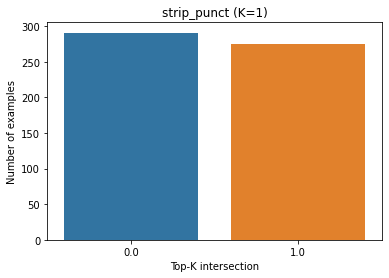

  0%|          | 2/566 [00:00<00:36, 15.54it/s]

Mean top-K intersection: 0.48586572438162545


100%|██████████| 566/566 [00:36<00:00, 15.44it/s]


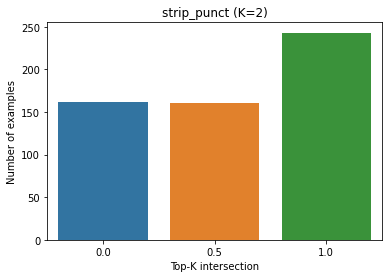

  0%|          | 2/566 [00:00<00:36, 15.40it/s]

Mean top-K intersection: 0.5715547703180212


100%|██████████| 566/566 [00:36<00:00, 15.39it/s]


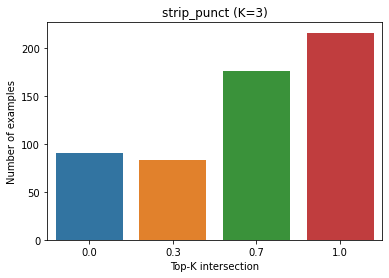

  0%|          | 2/566 [00:00<00:35, 16.07it/s]

Mean top-K intersection: 0.6432862190812721


100%|██████████| 566/566 [00:36<00:00, 15.51it/s]


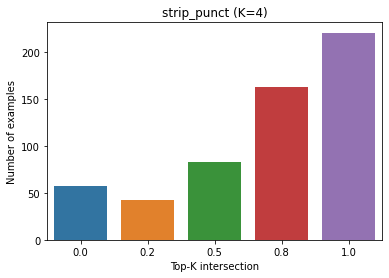

  0%|          | 2/566 [00:00<00:34, 16.26it/s]

Mean top-K intersection: 0.7090106007067137


100%|██████████| 566/566 [00:36<00:00, 15.45it/s]


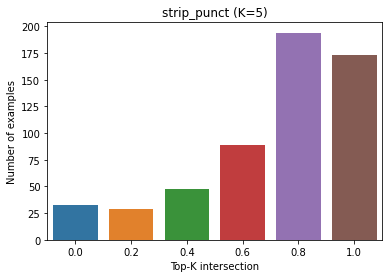

  0%|          | 2/566 [00:00<00:35, 15.91it/s]

Mean top-K intersection: 0.7183745583038869


100%|██████████| 566/566 [00:36<00:00, 15.35it/s]


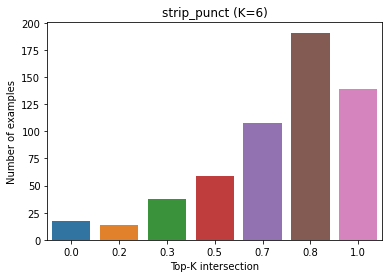

  0%|          | 2/566 [00:00<00:37, 15.18it/s]

Mean top-K intersection: 0.7263250883392226


100%|██████████| 566/566 [00:36<00:00, 15.37it/s]


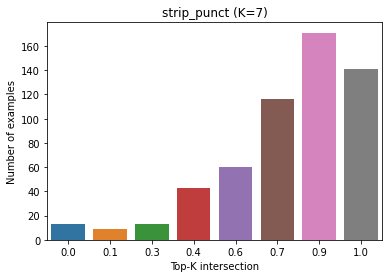

  0%|          | 2/566 [00:00<00:41, 13.70it/s]

Mean top-K intersection: 0.7669611307420495


100%|██████████| 566/566 [00:37<00:00, 15.29it/s]


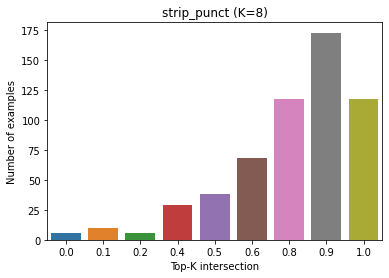

  0%|          | 2/566 [00:00<00:38, 14.51it/s]

Mean top-K intersection: 0.7803886925795054


100%|██████████| 566/566 [00:37<00:00, 15.19it/s]


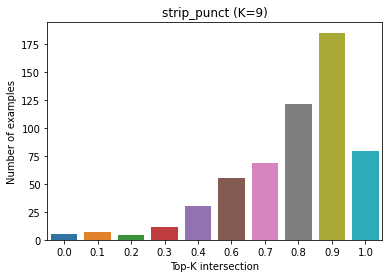

  0%|          | 2/566 [00:00<00:35, 15.74it/s]

Mean top-K intersection: 0.7780918727915194


100%|██████████| 566/566 [00:36<00:00, 15.34it/s]


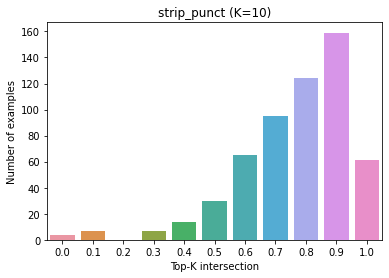

Mean top-K intersection: 0.7636042402826856


In [ ]:
plot_perturbations(df=perturb_dev_df, perturbation_name='strip_punct')

### Add typos perturbation

In [ ]:
perturb_dev_df = dev_df_checklisted.copy()[
  (dev_df_checklisted['success_add_typos'] == 1) &  # Successfully perturbed
  (dev_df_checklisted['predictions_add_typos'] == dev_df_checklisted['predictions']) &  # Prediction unchanged
  (dev_df_checklisted['label'] == dev_df_checklisted['predictions'])  # Correct prediction
].reset_index(drop=True)

perturb_dev_df.shape

(557, 15)

Partition explainer: 558it [02:43,  3.21it/s]
Partition explainer: 558it [02:44,  3.19it/s]
100%|██████████| 557/557 [00:35<00:00, 15.49it/s]


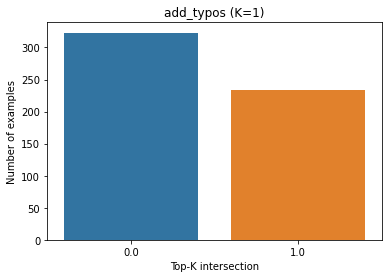

  0%|          | 2/557 [00:00<00:36, 15.37it/s]

Mean top-K intersection: 0.42010771992818674


100%|██████████| 557/557 [00:36<00:00, 15.32it/s]


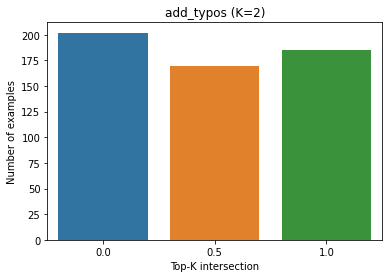

  0%|          | 2/557 [00:00<00:35, 15.63it/s]

Mean top-K intersection: 0.48473967684021546


100%|██████████| 557/557 [00:36<00:00, 15.37it/s]


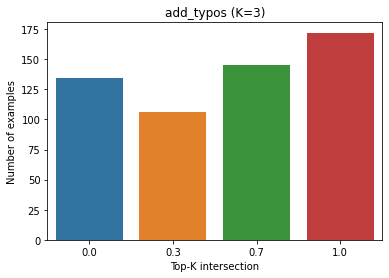

  0%|          | 2/557 [00:00<00:35, 15.54it/s]

Mean top-K intersection: 0.5481149012567326


100%|██████████| 557/557 [00:36<00:00, 15.32it/s]


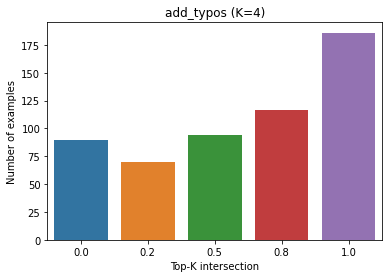

  0%|          | 2/557 [00:00<00:37, 14.73it/s]

Mean top-K intersection: 0.6114901256732495


100%|██████████| 557/557 [00:36<00:00, 15.30it/s]


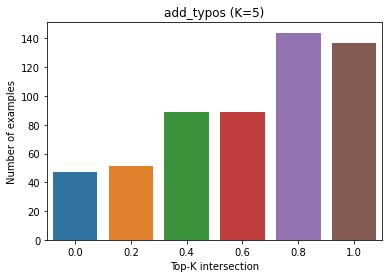

  0%|          | 2/557 [00:00<00:38, 14.57it/s]

Mean top-K intersection: 0.6308797127468582


100%|██████████| 557/557 [00:37<00:00, 14.93it/s]


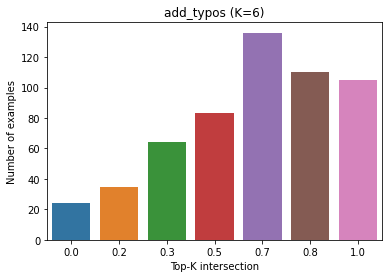

  0%|          | 2/557 [00:00<00:35, 15.46it/s]

Mean top-K intersection: 0.6389587073608617


100%|██████████| 557/557 [00:36<00:00, 15.23it/s]


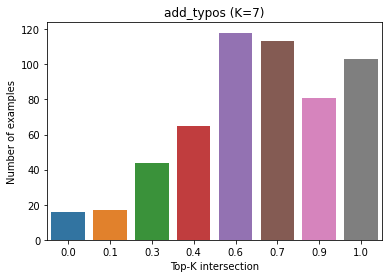

  0%|          | 2/557 [00:00<00:36, 15.09it/s]

Mean top-K intersection: 0.6583482944344704


100%|██████████| 557/557 [00:36<00:00, 15.27it/s]


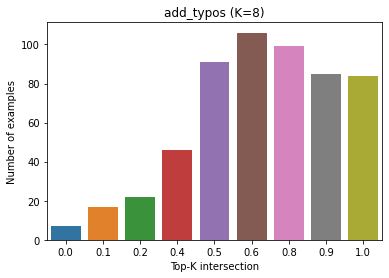

  0%|          | 2/557 [00:00<00:36, 15.25it/s]

Mean top-K intersection: 0.6701974865350089


100%|██████████| 557/557 [00:36<00:00, 15.24it/s]


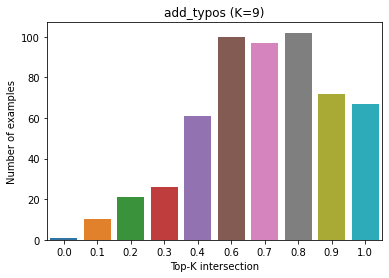

  0%|          | 2/557 [00:00<00:36, 15.34it/s]

Mean top-K intersection: 0.6798922800718132


100%|██████████| 557/557 [00:36<00:00, 15.23it/s]


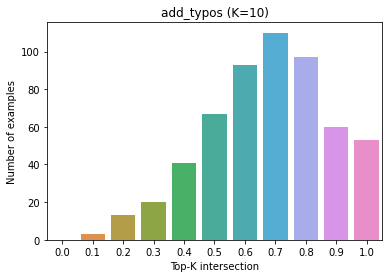

Mean top-K intersection: 0.6754039497307002


In [ ]:
plot_perturbations(df=perturb_dev_df, perturbation_name='add_typos')

### Contract sentence perturbation

In [ ]:
perturb_dev_df = dev_df_checklisted.copy()[
  (dev_df_checklisted['success_contract_sent'] == 1) &  # Successfully perturbed
  (dev_df_checklisted['predictions_contract_sent'] == dev_df_checklisted['predictions']) &  # Prediction unchanged
  (dev_df_checklisted['label'] == dev_df_checklisted['predictions'])  # Correct prediction
].reset_index(drop=True)

perturb_dev_df.shape

(51, 15)

In [ ]:
plot_perturbations(df=perturb_dev_df, perturbation_name='contract_sent')

Partition explainer: 52it [00:15,  1.19it/s]


KeyError: ignored

TODO Fix set logic

## Open questions

- Plots change slightly on separate runs - why is this?
- How to deal with perturbation changing token?
  - How to handle duplicate tokens? (potential bug in code for k-intersection)